In [ ]:
import os
import random
import numpy as np
import scipy.io
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.animation import FuncAnimation, PillowWriter
import cv2
import torchvision.transforms.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# SIN MAPA DE PROFUNDIDAD
class NYUDatasetNoDepth(Dataset):
    def __init__(self,
                 rgb_dir,
                 input_size=None,
                 dof_levels=5):
        self.rgb_dir    = rgb_dir
        self.input_size = input_size
        self.dof_levels = dof_levels

        # Solo archivos válidos
        base_files = sorted([
            f for f in os.listdir(rgb_dir)
            if os.path.isfile(os.path.join(rgb_dir, f)) and f.endswith('.png')
        ])

        # Pares (nombre de archivo, nivel de dof)
        self.pairs = [
            (filename, dof_level)
            for filename in base_files
            for dof_level in range(dof_levels)
        ]

        if self.input_size is not None:
            self.transform = T.Compose([
                T.Resize(self.input_size),
                T.ToTensor()
            ])
        else:
            self.transform = T.ToTensor()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        name, dof = self.pairs[idx]

        # Cargar imagen con desenfoque
        dof_path = os.path.join(self.rgb_dir, f'dof{dof}', name)
        if not os.path.isfile(dof_path):
            raise FileNotFoundError(f"No se encontró la imagen desenfocada: {dof_path}")

        # Cargar ground truth (imagen nítida)
        gt_path = os.path.join(self.rgb_dir, name)

        dof_img = Image.open(dof_path).convert('RGB')
        gt_img  = Image.open(gt_path).convert('RGB')

        # Transformar
        dof_img = self.transform(dof_img)
        gt_img  = self.transform(gt_img)

        return {
            'image': dof_img,
            'gt': gt_img,
            'dof': dof,
            'name': name
        }


In [ ]:
rgb_dir = '/content/drive/MyDrive/Dataset/nyu_rgb'
dataset = NYUDatasetNoDepth(
    rgb_dir=rgb_dir,
    input_size=None,
    dof_levels=5,
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


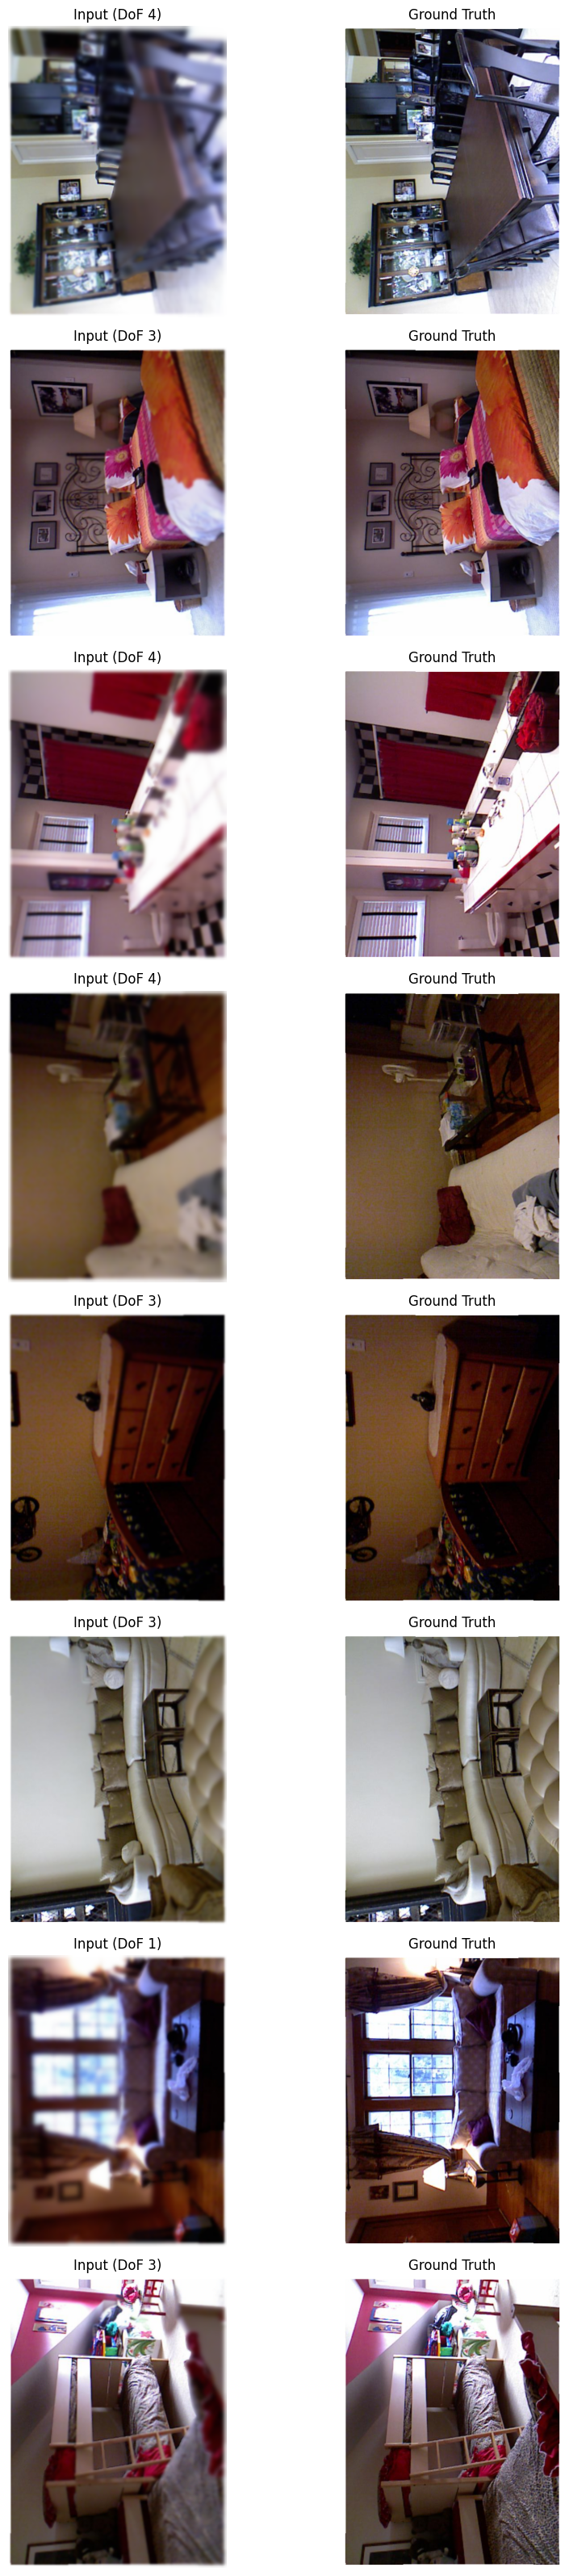

In [ ]:
def show_batch(batch, max_images=8):
    images = batch['image']
    gts    = batch['gt']
    dofs   = batch['dof']

    batch_size = min(images.size(0), max_images)
    fig, axs = plt.subplots(batch_size, 2, figsize=(10, 4 * batch_size))

    if batch_size == 1:
        axs = [axs]

    for i in range(batch_size):
        img = F.to_pil_image(images[i].cpu())
        gt  = F.to_pil_image(gts[i].cpu())
        dof = dofs[i].item()

        axs[i][0].imshow(img)
        axs[i][0].set_title(f'Input (DoF {dof})')
        axs[i][0].axis('off')

        axs[i][1].imshow(gt)
        axs[i][1].set_title('Ground Truth')
        axs[i][1].axis('off')

    plt.tight_layout()
    plt.show()


batch = next(iter(dataloader))
show_batch(batch)